## Set project directory

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/My\ Drive/CV_incubator/IncubatorCVProject

/content/drive/My Drive/CV_incubator/IncubatorCVProject


In [ ]:
!ls src

Basic_CNN_Architecture.py   dataset.py		    __pycache__
BasicCNN_withfeat_64x64.py  feature_engineering.py  train_valid.py
data_loader.py		    main_two.py		    utils.py


## Import libraries and load data

In [30]:
import pandas as pd
from torchvision.transforms import ToTensor,Resize,Compose,Grayscale
from src.data_loader import SquarePadding
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import pickle
import time
from src.BasicCNN_withfeat_64x64 import BasicCNN_w_features_64x64 
from src.train_valid import train, validation
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder

In [31]:
# Path to the folder where all images are stored
# data_path = '../indoor'
data_path = '../dog-breed-identification'

#### Pytorch dataset

In [32]:
dataset = ImageFolder(data_path,transform=Compose([
    SquarePadding(),
    Resize((64,64)),
    ToTensor()]))

<BarContainer object of 120 artists>

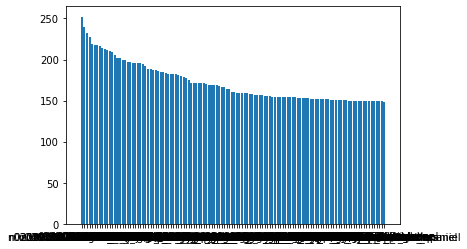

In [33]:
import os
import matplotlib.pyplot as plt
% matplotlib inline

classes = [root.split('/')[-1] for root,dir,files in os.walk(data_path)][1:]
class_count = [len(files) for root,dir,files in os.walk(data_path)][1:]
cls = list(zip(classes,class_count))
cls = sorted(cls,key = lambda cls: cls[1], reverse=True)
plt.bar([x[0] for x in cls],[x[1] for x in cls])

In [34]:
#Variables for splitting the dataset into train/test
validation_split = .2
test_split = .1
batch_size = 16
shuffle_dataset = True
random_seed = 42

# Split 
dataset_size = len(dataset)
indices = list(range(dataset_size))
split_idx1 = int(np.floor((validation_split+test_split) * dataset_size))
split_idx2 = int(np.floor(test_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
test_indices, val_indices, train_indices = indices[:split_idx2], indices[split_idx2:split_idx1], indices[split_idx1:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

#### Engineered features(eigenvectors)


In [35]:
dataset_feat = ImageFolder(data_path,transform=Compose([
    SquarePadding(),
    Resize((64,64)),
    Grayscale(num_output_channels=1),
    ToTensor()]))

train_loader_feat = torch.utils.data.DataLoader(dataset_feat, batch_size=len(train_indices), 
                                           sampler=train_sampler)

In [36]:
sample = next(iter(train_loader_feat))
# pickle.dump(sample[0], open( "imagelist_indoor_train.p", "wb" ) )

In [37]:
image_list = sample[0]

In [ ]:
file = open("imagelist_indoor_train.p", "rb" )
image_list = pickle.load(file)

In [38]:
from sklearn.decomposition import PCA
from src.utils import unravel_image, ravel_image_vec, plot_image_grid

In [39]:
def PCA_images_list(images_list,n_components=100):
    #Initialize X
    img_h,img_w = images_list.size()[-2:]
    default_image_size = images_list.size()[-2:]
    num_pixels = img_h*img_w
    X = images_list.flatten(1).numpy()
    #Now grab all the images and push them into X

    #Perform PCA on X
    PCA_model = PCA(n_components=n_components)
    PCA_model.fit(X)
    eig_vecs =PCA_model.components_
    eig_vals=PCA_model.explained_variance_ 
    #NOTE!!! The return of this is of shape (n_components,length_of_eig_vec).
    #Each row is an eigenvectors, and the first row is the eigenvector with the
    #largest eigenvalue
   
    #"ravel" each eigenvector and push into new_eigvec_list
    # new_eigvec = torch.Tensor(eig_vecs).view((n_components,img_h,img_w))
    new_eigvec = torch.Tensor(eig_vecs)
    #Now, return the eigval-eigvec pairs
    return (eig_vals,new_eigvec)

In [40]:
(eig_vals,eig_image_list) = PCA_images_list(image_list)

In [41]:
train_feat = valid_feat = eig_image_list

In [42]:
def prepare_eigen_component_features(images_list,eig_vecs):
    '''
    Inputs:
        images_list: list of images (images are ndarrays, usually of 2 dimensions (e.g 128x128))
        eig_vecs: an 2d array of eigenvectors, where each eigenvector is a column
    Outputs:
        return: returns a feature matrix, where the rows of the feature matrix correspond to the 
        features of images. First image is the first row of the matrix, last image is the last row.
        The features are the components of the eigenvectors (which were passed in the input 'eig_vecs')
    '''
    #n_components = len(eig_vecs.shape)
    feat = torch.transpose(eig_vecs,0,1)
    image_vec = torch.flatten(images_list,1)
    feature_matrix = image_vec@feat
        
    return feature_matrix

## Training

In [43]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn import metrics

from skimage import io, color

import time
import os
import pickle

import matplotlib.pyplot as plt

def train(epoch, model, optimizer, criterion, loader, device, train_feat):

    model.train()

    running_loss = 0.0
    epoch_loss = 0.0
    total_samples = 0
    correct = 0
    mysoftmax = nn.Softmax(dim=1)

    for batch_idx, (image, label) in enumerate(loader):
        
        
        batch_size = image.size(0)
        gray_image = torch.stack([transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()])(image[i]) 
            for i in range(image.size(0))])
        
        image = image.to(device)
       
        #label = samples[1].squeeze().to(device)
        label = label.to(device)
        
        #label = torch.tensor(label, dtype=torch.long, device=device)
        #print(image)
        
        feat = prepare_eigen_component_features(gray_image,train_feat).to(device)
        output = model(image,feat)
        _, preds = torch.max(output, dim = 1)
    
        loss = criterion(output, label)
        running_loss += loss.item()
        epoch_loss += loss.item()

        total_samples += image.shape[0]
        correct += torch.sum(preds == label).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss = 0.0

    training_accuracy = correct / total_samples

    return epoch_loss / len(loader), training_accuracy

def validation(epoch, model, optimizer, criterion, loader, device, valid_feat, multiclass=True):

    model.eval( )

    running_loss = 0.0
    total_samples = 0
    correct = 0
    mysoftmax = nn.Softmax(dim=1)

    # this part needs to be adapted later based on task 3
    preds_list = []
    truelabels_list = []
    probas_list = []

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(loader):
            batch_size = image.size(0)
            gray_image = torch.stack([transforms.Compose([
                transforms.ToPILImage(),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()])(image[i]) 
                for i in range(image.size(0))])
            
            image = image.to(device)
          
            #label = samples[1].squeeze().to(device)
            label = label.to(device)
            
            #label = torch.tensor(label, dtype=torch.long, device=device)
            #print(image)
            
            feat = prepare_eigen_component_features(gray_image,valid_feat).to(device)
            output = model(image,feat)
            output_softmax = mysoftmax(output)

            _, preds = torch.max(output, dim = 1)

            loss = criterion(output, label)
            running_loss += loss.item()

            total_samples += image.shape[0]
            correct += torch.sum(preds == label).item()

            preds_list.append(preds.cpu().numpy())
            truelabels_list.append(label.cpu().numpy())
            probas_list.append(output_softmax.cpu().numpy())

        valid_accuracy = correct / total_samples

        probas_list = np.vstack(probas_list)
        truelabels_list = np.concatenate(truelabels_list)
        preds_list = np.concatenate(preds_list)

        if multiclass == False:
            auc_score = metrics.roc_auc_score(truelabels_list, preds_list)

        else:
            # Computes the average AUC of all possible pairwise combinations of classes
            # Insensitive to class imbalance when average == 'macro'
            auc_score = metrics.roc_auc_score(truelabels_list, probas_list, multi_class='ovo')


        return running_loss / len(loader), valid_accuracy, preds_list, truelabels_list, probas_list, auc_score

In [44]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [45]:
import torch
import torch.nn as nn

class BasicCNN_w_features_64x64(nn.Module):
    def __init__(self,num_classes):
        super(BasicCNN_w_features_64x64, self).__init__()

        in_channels= 3  
        conv1_out_channels= 8 
        conv2_out_channels = 8
        lin1_out_channels= 64
        kernel_size = 5
        stride = 2
        padding = 2
        dropout = None
        activation = nn.ReLU(inplace = False)
        
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=conv1_out_channels,
            kernel_size=kernel_size, 
            stride=stride,
            padding=padding,
            padding_mode='zeros'
            )
        self.conv2 = nn.Conv2d(
            in_channels=conv1_out_channels, 
            out_channels=conv2_out_channels,
            kernel_size=kernel_size, 
            stride=stride,
            padding=padding,
            padding_mode='zeros'
            )
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=4*4*conv2_out_channels + 100,
                             out_features=lin1_out_channels)
        # infeat_size = (featmap_size + num_img * num_eigenvecs)
        self.fc2 = nn.Linear(in_features=lin1_out_channels,
                             out_features=num_classes)
        
        if dropout is not None:
            if (dropout > 1 or dropout < 0) or type(dropout) is not float:
                raise ValueError("Give Dropout Probability between 0 and 1")    
            else:
                self.dropout1 = nn.Dropout(p = dropout, inplace = False)
                self.dropout2 = nn.Dropout(p = dropout, inplace = False)
        else:
            self.dropout1 = None
            self.dropout2 = None
        
        self.activation = activation
        self.softmax = nn.Softmax(dim=1)


    def forward(self,image,features):
        
        out = self.conv1(image)
        #print(1,out.size())
        out = self.activation(out)
        #print(2,out.size())
        out = self.pool1(out)
        #print(3,out.size())
        if self.dropout1 is not None:
            out = self.dropout2(out) 
        out = self.conv2(out)
        #print(4,out.size())
        out = self.activation(out)
        #print(5,out.size())
        out = self.pool2(out)
        #print(6,out.size())
        if self.dropout2 is not None:
            out = self.dropout2(out)
        out = self.flatten(out)
        out = torch.cat((out,features),1)
        out = self.fc1(out)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [47]:
num_classes=len(dataset.classes)

# training process
# to be finished later
model = BasicCNN_w_features_64x64(num_classes=num_classes)
model.to(device)
train_loss = nn.CrossEntropyLoss()
train_loss.to(device)
valid_loss = nn.CrossEntropyLoss()
valid_loss.to(device)
def train_valid(optimizer = optim.Adam(model.parameters()), epochs = 20, model = model,
                train_criterion = train_loss, train_loader = train_loader,
                valid_criterion = valid_loss, valid_loader = valid_loader,
                device = device, train_feat = train_feat, valid_feat = valid_feat):

    start_epoch = 1
    #or: best_val_acc = 0
    best_val_loss = np.inf

    history = {"train_loss":[], "train_acc":[],
                "valid_loss":[], "valid_acc":[], "valid_preds_list":[],
                "valid_truelabels_list":[], "valid_probas_list":[], "valid_auc_score":[]}

    start_time = time.time()

    for epoch in range(start_epoch, epochs + 1):

        train_loss, train_acc = train(epoch, model, optimizer, train_criterion, 
                                      train_loader, device, train_feat)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        print('epoch: ', epoch)
        print('{}: loss: {:.4f} acc: {:.4f}'.format('training', train_loss, train_acc))

        valid_loss, valid_acc, valid_preds_list, valid_truelabels_list, valid_probas_list, valid_auc_score = validation(epoch, model, optimizer, 
                                                        valid_criterion, valid_loader, 
                                                        device, valid_feat)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)
        history["valid_preds_list"].append(valid_preds_list)
        history["valid_truelabels_list"].append(valid_truelabels_list)
        history["valid_probas_list"].append(valid_probas_list)
        history["valid_auc_score"].append(valid_auc_score)

        print('{}: loss: {:.4f} acc: {:.4f} auc: {:.4f}'.format('validation', valid_loss, valid_acc, valid_auc_score))
        print()

        # save models(use valid loss as best model criterion, please change
        # criterion here if needed(eg. valid acc)
        is_best = valid_loss < best_val_loss
        best_val_loss = min(valid_loss, best_val_loss)

        if is_best:
            # please change model file path here
            best_model_file = "best_dry_run1.pth"
            torch.save(model.state_dict(), best_model_file)

        # save model from every training epoch
        # can be deleted if do not need this one, or adapt it to save 5th, 10th, 15th ...models
        model_file = "dry_run1" + str(epoch) + ".pth"

        torch.save(model.state_dict(), model_file)

        # save training/validation results
        with open("history.pkl", "wb") as fout:
            pickle.dump(history, fout)

    print('time elapsed:', time.time() - start_time)

    return history

results = train_valid(epochs = 100)

epoch:  1
training: loss: 4.7802 acc: 0.0194
validation: loss: 4.7802 acc: 0.0199 auc: 0.5187

epoch:  2
training: loss: 4.7707 acc: 0.0298
validation: loss: 4.7723 acc: 0.0269 auc: 0.5359

epoch:  3
training: loss: 4.7631 acc: 0.0384
validation: loss: 4.7713 acc: 0.0284 auc: 0.5392

epoch:  4
training: loss: 4.7541 acc: 0.0488
validation: loss: 4.7664 acc: 0.0361 auc: 0.5377

epoch:  5
training: loss: 4.7459 acc: 0.0581
validation: loss: 4.7654 acc: 0.0364 auc: 0.5423

epoch:  6
training: loss: 4.7378 acc: 0.0663
validation: loss: 4.7635 acc: 0.0361 auc: 0.5413

epoch:  7
training: loss: 4.7316 acc: 0.0731
validation: loss: 4.7581 acc: 0.0456 auc: 0.5422

epoch:  8
training: loss: 4.7240 acc: 0.0809
validation: loss: 4.7593 acc: 0.0419 auc: 0.5393

epoch:  9
training: loss: 4.7185 acc: 0.0869
validation: loss: 4.7562 acc: 0.0456 auc: 0.5431

epoch:  10
training: loss: 4.7123 acc: 0.0926
validation: loss: 4.7575 acc: 0.0429 auc: 0.5420

epoch:  11
training: loss: 4.7066 acc: 0.0990
val